In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ydata_profiling as pp
import seaborn as sns
import warnings
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression,LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
    

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def prediction_interp(date_strings, rounds_funds, inp_params):
    
    date_strings = date_strings[:inp_params["funding_rounds"]]
    
    rounds_funds = rounds_funds[:inp_params["funding_rounds"]]
    
    len_r = len(rounds_funds)
    
    cum_list = [sum(rounds_funds[0:x:1]) for x in range(0, len_r+1)]
    
    cumulative_sum = cum_list[1:]
    
    # Convert the list of strings to a DatetimeIndex
    date_index = pd.to_datetime(date_strings, format='%Y-%m-%d')
    
    founded_date = pd.to_datetime(inp_params["founded_date"], format='%Y-%m-%d')
    
    # Sample input data (replace with your own data)
    data = {
        "date": date_index,
        "amount": cumulative_sum,
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Set the date as the index
    df.set_index("date", inplace=True)

    # Create a time series
    ts = df["amount"]

    # Forecast for the next 3 years (36 months) using ARIMA
    model = sm.tsa.ARIMA(ts, order=(2, 1, 1))  # Adjust order as needed
    result = model.fit()

    # Generate future dates for forecasting
    future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=12), periods=5, freq="1Y")

    # Forecast future values
    forecast_values = result.predict(start=len(ts), end=len(ts) + 4, dynamic=True, typ='levels')

    # Create a DataFrame for the forecast
    forecast_df = pd.DataFrame({"date": future_dates, "funding_total_usd": forecast_values})
    
    forecast_df['Industry_Group'] = inp_params['Industry_Group']
    
    forecast_df['country_code'] = inp_params['country_code']
    
    forecast_df['time_between_first_last_funding'] = (pd.to_datetime(forecast_df['date'], format='%Y-%m-%d') - date_index[0]).dt.days
    
    forecast_df['days_in_business'] = (pd.to_datetime(forecast_df['date'], format='%Y-%m-%d') - founded_date).dt.days
    
    number_of_rounds = [*range(inp_params["funding_rounds"]+1,inp_params["funding_rounds"] + 6)]
    
    forecast_df["funding_rounds"] = number_of_rounds
    
    return forecast_df.reset_index(drop=True)

In [44]:
date_strings = ['2015-01-31', '2017-02-28', '2018-03-31', '2019-03-31', '2020-03-31']
rounds_funds = [0, 2100, 2500, 0, 4000]
api_input = {
    "Industry_Group": 'Software',          #string
    "country_code": "USA",                 #"USA" or "Other"
    "funding_rounds": 5,     #int 1-8
    "founded_date": '2012-01-31'
}


pred_data = prediction_interp(date_strings, rounds_funds, api_input)

/home/janchik/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/janchik/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/janchik/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/janchik/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning

In [45]:
len_r = len(rounds_funds)
    
cum_list = [sum(rounds_funds[0:x:1]) for x in range(0, len_r+1)]
    
cumulative_sum = cum_list[1:]

list_of_success = 

cumulative_sum

[0, 2100, 4600, 4600, 8600]

In [48]:
pred_data

,date,funding_total_usd,Industry_Group,country_code,time_between_first_last_funding,days_in_business,funding_rounds
0,2021-12-31,8587.703635,Software,USA,2526,3622,6
1,2022-12-31,11707.542831,Software,USA,2891,3987,7
2,2023-12-31,12382.311730,Software,USA,3256,4352,8
3,2024-12-31,14965.781983,Software,USA,3622,4718,9
4,2025-12-31,16059.239598,Software,USA,3987,5083,10


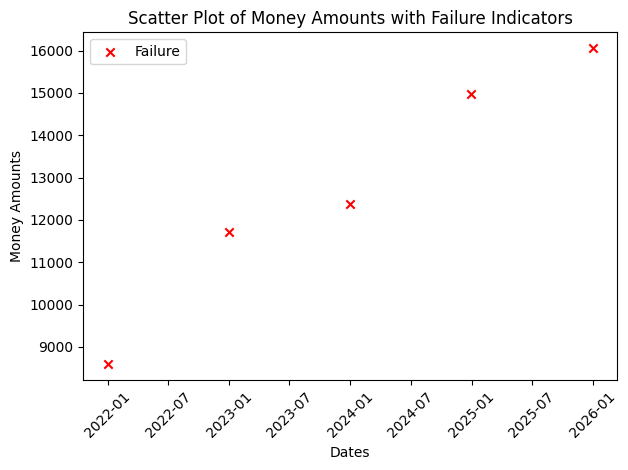

In [60]:
import matplotlib.pyplot as plt

dates = pred_data['date']
money_amounts = pred_data['funding_total_usd']
failure_success = [0, 0, 0, 0, 0]

# Find the index of the first success
first_success_index = failure_success.index(1) if 1 in failure_success else len(failure_success)

# Separate data into failure and success portions
failure_dates = dates[:first_success_index]
failure_amounts = money_amounts[:first_success_index]

# Create a scatter plot for failures
plt.scatter(failure_dates, failure_amounts, label='Failure', color='red', marker='x')

# If there are success data points after the first success, separate and plot them
if first_success_index < len(dates):
    success_dates = dates[first_success_index]
    success_amounts = money_amounts[first_success_index]
    plt.scatter(success_dates, success_amounts, label='Success', color='green', marker='o')


# Labeling and title
plt.xlabel('Dates')
plt.ylabel('Money Amounts')
plt.title('Scatter Plot of Money Amounts with Failure Indicators')

# Adding a legend
plt.legend()

# Rotating x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [61]:
pred_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             5 non-null      datetime64[ns]
 1   funding_total_usd                5 non-null      float64       
 2   Industry_Group                   5 non-null      object        
 3   country_code                     5 non-null      object        
 4   time_between_first_last_funding  5 non-null      int64         
 5   days_in_business                 5 non-null      int64         
 6   funding_rounds                   5 non-null      int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 408.0+ bytes
